<a href="https://colab.research.google.com/github/jjcheung/ctcuc22/blob/main/Relational_Database_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Member 1: Lorraine Neo

Member 2: Cheung Jun Jie

Design and implement a >1 table relational database project with Python and SQLite.

Your project should perform the standard CRUD operations plus at least 1 aggregation function.

Task: 

Manage a database of COVID-19 patients and clusters 

ER-diagram:

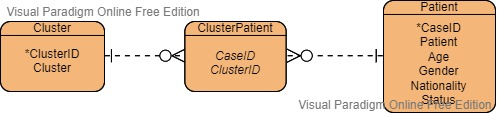 


Table specification:

Patient (**CaseID**, Patient, Age, Gender, Nationality, Status)

ClusterPatient (*CaseID*, *ClusterID*)

Cluster (**ClusterID**, Cluster)

Legend: **Bold - Primary Key**, Italics - Foreign Key


Python implementation:

**Menu**

In [ ]:
# program menu
def menu():
    print('COVID 19 Database Query')
    
    print('1. List all tables')
    print('2. Show table records')
    print('3. Insert record(s)')
    print('4. Update record(s)')
    print('5. Delete record(s)')
    print('6. Show patients by Cluster')
    print('7. [Pro Mode] Enter SQL Command')

    print('0. Exit')

**Database creation**

In [ ]:
import sqlite3
import csv

# create database connection
connection = sqlite3.connect('covid.db')

# create cursor
cursor = connection.cursor()

# create tables
cursor.execute('CREATE TABLE IF NOT EXISTS Patient (CaseID INTEGER, Patient TEXT, Age INTEGER, Gender TEXT, Nationality TEXT, Status TEXT, PRIMARY KEY(CaseID) );')
cursor.execute('CREATE TABLE IF NOT EXISTS Cluster (ClusterID INTEGER, Cluster TEXT, PRIMARY KEY(ClusterID));')
cursor.execute('CREATE TABLE IF NOT EXISTS ClusterPatient (CaseID INTEGER, ClusterID INTEGER, FOREIGN KEY(CaseID) REFERENCES Patient(CaseID), FOREIGN KEY(ClusterID) REFERENCES Cluster(ClusterID) );')

#empty lists to store values from csv
cluster = []
clusterid = 1
patient = []
clusterpatient = []

#reading csv
with open('covid.csv', newline = '') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        patient.append([row['CaseID'], row['Patient'], row['Age'], row['Gender'], row['Nationality'], row['Status']])
        if row['ClusterName'] != '': #if cluster is identified / linked
            if ';' in row['ClusterName']: #if patient belong to multiple clusters
                clist = row['ClusterName'].split(';') #list of clusters patient belong to
            else: #if patient belongs to only 1 cluster
                clist = [row['ClusterName']]
            for c in clist: 
                cid = -1 #to search for cluster id
                for lst in cluster: 
                    if c in lst: #if existing cluster
                        cid = lst[0]
                        break
                if cid == -1: #if new cluster
                    cluster.append([clusterid, c])  #append to list of clusters, with id
                    clusterpatient.append([row['CaseID'], clusterid]) #append to list for cluster-patient table
                    clusterid += 1                  #new id for next cluster
                else:
                    clusterpatient.append([row['CaseID'], cid])
        
#using values in lists to add to tables in database       
cursor.executemany('INSERT INTO Patient (CaseID, Patient, Age, Gender, Nationality, Status) VALUES (?, ?, ?, ?, ?, ?);', tuple(patient))
cursor.executemany('INSERT INTO ClusterPatient (CaseID, ClusterID) VALUES (?, ?);', tuple(clusterpatient))
cursor.executemany('INSERT INTO Cluster (ClusterID, Cluster) VALUES (?, ?);', tuple(cluster))

connection.commit()
connection.close();

**Execution of programme**

In [ ]:
def list_tables(cursor):
    cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table'")
    
    print('List of Tables:')
    result = cursor.fetchall()
    for row in result:
        print(row[0])
    print()

def show_records(cursor):
    list_tables(cursor)
    table = input('Choose table: ')
    query = 'SELECT * FROM ' + table +';'
    
    cursor.execute(query)
    name = [col[0] for col in cursor.description]
    print(name)
    result = cursor.fetchall()
    for row in result:
        print(row)
    print()

def insert_records(cursor, connection):
    list_tables(cursor)
    table = input('Choose table: ')
    if table == 'Cluster':
        cursor.execute("SELECT * FROM Cluster")
        result = cursor.fetchall()
        clus_id = result[-1][0] + 1
        print(f'Allocated ClusterID: {clus_id}')
        name = input('Enter Cluster Name: ')
        cursor.execute("INSERT INTO Cluster (ClusterID, Cluster) VALUES (?, ?);", (clus_id, name))
    elif table == 'ClusterPatient':
        caseid = int(input('Enter Case ID: '))
        clus_id = int(input('Enter Cluster ID: '))
        cursor.execute("INSERT INTO ClusterPatient (CaseID, ClusterID) VALUES (?,?);", (caseid, clus_id))
    elif table == 'Patient':
        #print("Function in Maintenance.")
        cursor.execute("SELECT * FROM Patient")
        result = cursor.fetchall()
        caseid = result[-1][0] + 1
        print(f'Allocated Case ID: {caseid}')
        name = input('Enter Patient Name: ')
        age = int(input('Enter Patient Age: '))
        gender = input('Enter Patient Gender: ')
        ntion = input('Enter Nationality of Patient: ')
        status = input('Enter Status of Patient: ')
        cursor.execute('INSERT INTO Patient (CaseID, Patient, Age, Gender, Nationality, Status) VALUES (?, ?, ?, ?, ?, ?);', (caseid, name, age, gender, ntion, status))
    connection.commit()
    print('Record inserted.')
    print()

def update_records(cursor, connection):
    list_tables(cursor)
    table = input('Choose table: ')
    if table == 'Cluster':
        clus_id = int(input('Enter Cluster ID: '))
        name = input('Enter Updated Cluster Name: ')
        cursor.execute("UPDATE Cluster SET Cluster = ? WHERE ClusterID = ?;", (name, clus_id))
    elif table == 'ClusterPatient':
        print("Please use delete and insert functions to update records in this table.")
    elif table == 'Patient':
        case = int(input("Enter Case ID: "))
        status = input("Enter current status of Patient: ")
        cursor.execute("UPDATE Patient SET Status = ? WHERE CaseID = ?;", (status, case))
    connection.commit()
    print('Record updated.')
    print()

def delete_records(cursor):
    list_tables(cursor)
    table = input('Choose table: ')
    if table == 'Cluster':
        clus_id = input('Enter Cluster ID: ')
        cursor.execute("DELETE FROM Cluster WHERE ClusterID = ?;", (clus_id))
    elif table == 'ClusterPatient':
        case = input('Enter Case ID: ')
        clus_id = input('Enter Cluster ID: ')
        cursor.execute("DELETE FROM ClusterPatient WHERE CaseID = ? AND ClusterID = ?;", (case, clus_id))
    elif table == 'Patient':
        case = input("Enter Case ID: ")
        cursor.execute("DELETE FROM Patient WHERE CaseID = ?;", (case))
    connection.commit()
    print('Record deleted.')
    print()

def patient_by_cluster(cursor):
    results = cursor.execute("""
        SELECT p.Patient, c.Cluster
        FROM Patient AS p 
        INNER JOIN ClusterPatient AS cp ON p.CaseID = cp.CaseID 
        INNER JOIN Cluster AS c ON cp.ClusterID = c.ClusterID
        ORDER BY c.Cluster;""")
    for record in results:
        print(record)
    print()

def promode(cursor, connection):
    query = input('Enter SQL Command: ')
    cursor.execute(query)
    result = cursor.fetchall()
    for row in result:
        print(row)
    connection.commit()
    print()

def main():
    # create database connection
    connection = sqlite3.connect('covid.db')

    # create cursor
    cursor = connection.cursor()
    option = '-1'
    while option != '0':
        menu()
        option = input('Please enter option: ')
        print()
        if option == '1':
            list_tables(cursor)           
        elif option == '2':
            show_records(cursor)
        elif option == '3':
            insert_records(cursor, connection)
        elif option == '4':
            update_records(cursor, connection)
        elif option == '5':
            show_records(cursor)
        elif option == '6':
            patient_by_cluster(cursor)
        elif option == '7':
            promode(cursor, connection)
        elif option == '0':
            print('Thank you for using database.')
        else:
            print('Invalid option. Please try again!')
    print('Goodbye!')

    connection.close()

main()

COVID 19 Database Query
1. List all tables
2. Show table records
3. Insert record(s)
4. Update record(s)
5. Delete record(s)
6. Show patients by Cluster
7. [Pro Mode] Enter SQL Command
0. Exit
Please enter option: 4

List of Tables:
Patient
Cluster
ClusterPatient

Choose table: Cluster
Enter Cluster ID: 12
Enter Updated Cluster Name: Test2
Record updated.

COVID 19 Database Query
1. List all tables
2. Show table records
3. Insert record(s)
4. Update record(s)
5. Delete record(s)
6. Show patients by Cluster
7. [Pro Mode] Enter SQL Command
0. Exit
Please enter option: 6

('26 year old male Singapore Citizen', 'Boulder+ Gym')
('28 year old male Singapore Citizen', 'Boulder+ Gym')
('27 year old female Singapore Citizen', 'Boulder+ Gym')
('34 year old male Singapore Citizen', 'Boulder+ Gym')
('35 year old female Filipino national', 'Boulder+ Gym')
('30 year old male Singapore Citizen', 'Boulder+ Gym')
('30 year old female Singapore Citizen', 'Boulder+ Gym')
('24 Year Old Male Singaporean', 

## Some interesting aggregate functions

In [ ]:
import sqlite3

# create database connection
connection = sqlite3.connect('covid.db')

# create cursor
cursor = connection.cursor()


# Counting how many patients are not in any particular cluster, i.e. unlinked cases
cursor.execute("SELECT COUNT(*) From Patient WHERE CASEID Not IN (SELECT CASEID From ClusterPatient )")

results = cursor.fetchall()

print("Number of unlinked cases: ")
for record in results:
    print(record[0])



# Count number of patients from various nationality
cursor.execute("SELECT Nationality, COUNT(Nationality) From Patient GROUP BY Nationality ORDER BY COUNT(Nationality) DESC")

results = cursor.fetchall()

print("\nComposition of Patients by Nationality: ")
for record in results:
    print(record[0] + ": " + str(record[1]))

# Clusters with largest number of patients
cursor.execute("SELECT Cluster.Cluster, COUNT(ClusterPatient.ClusterID) From ClusterPatient \
INNER JOIN Cluster ON ClusterPatient.ClusterID = Cluster.ClusterID \
GROUP BY ClusterPatient.ClusterID \
ORDER BY COUNT(ClusterPatient.ClusterID) DESC \
LIMIT 3")

results = cursor.fetchall()

print("\nTop 3 largest clusters: ")
for record in results:
    print(record[0] + ": " + str(record[1]) + " infections.")

# destroy database connection (and cursor)
connection.close()

Number of unlinked cases: 
380

Composition of Patients by Nationality: 
Singaporean: 373
Chinese: 20
Indonesian: 19
Filipino: 13
British: 11
Malaysian: 10
Australian: 9
American: 7
German: 6
Indian: 6
Bangladeshi: 5
French: 5
Dutch: 3
Swiss: 3
Irish: 2
Myanmarian: 2
New zealander: 2
Spanish: 2
Swedish: 2
Belgian: 1
Brazilian: 1
Canadian: 1
Colombian: 1
Danish: 1
Italian: 1
Japanese: 1
Russian: 1
Thai: 1

Top 3 largest clusters: 
Jurong Safra: 45 infections.
Grace Assembly of God: 17 infections.
Wizlearn Technologies: 14 infections.


**Additional CRUD commands**

In [ ]:
# query for patients in each cluster, ordered by cluster
results1 = cursor.execute("""
    SELECT p.Patient, c.Cluster
    FROM Patient AS p 
    INNER JOIN ClusterPatient AS cp ON p.CaseID = cp.CaseID 
    INNER JOIN Cluster AS c ON cp.ClusterID = c.ClusterID
    ORDER BY c.Cluster;""")
for record in results1:
    print(record)
print()

# query for Singaporean patients
results2 = cursor.execute("SELECT * from Patient WHERE Nationality = 'Singaporean';")
#results = cursor.fetchall()
for record in results2:
    print(record)
print()

# determine the average age of patients
results3 = cursor.execute("SELECT AVG(Age) from Patient;")
for record in results3:
    print(record)
print()

#updating patient status to recovered
cursor.execute("UPDATE Patient SET Status = 'Recovered' WHERE CaseID = '507';") 
connection.commit()

#delete a case from the database
cursor.execute("DELETE FROM Patient WHERE CaseID = '506';")
connection.commit()
cursor.execute("SELECT * FROM Patient;")
results = cursor.fetchall()
for record in results:
    print(record)
print()

# make changes permanent
connection.commit()



# destroy database connection (and cursor)
connection.close()

('26 year old male Singapore Citizen', 'Boulder+ Gym')
('28 year old male Singapore Citizen', 'Boulder+ Gym')
('27 year old female Singapore Citizen', 'Boulder+ Gym')
('34 year old male Singapore Citizen', 'Boulder+ Gym')
('35 year old female Filipino national', 'Boulder+ Gym')
('30 year old male Singapore Citizen', 'Boulder+ Gym')
('30 year old female Singapore Citizen', 'Boulder+ Gym')
('24 Year Old Male Singaporean', 'Boulder+ Gym')
('30 Year Old Male German', 'Boulder+ Gym')
('29 Year Old Male Singaporean', 'Boulder+ Gym')
('28 year old male Singapore Citizen', 'CNY Family Gathering at Mei Hwan Dr')
('79 year old female Singapore Citizen', 'CNY Family Gathering at Mei Hwan Dr')
('27 year old Singapore Citizen', 'CNY Family Gathering at Mei Hwan Dr')
('25 year old male Singapore Citizen', 'CNY Family Gathering at Mei Hwan Dr')
('38 year old female Singapore Citizen', 'CNY Family Gathering at Mei Hwan Dr')
('35 year old female Singapore Citizen', 'CNY Family Gathering at Mei Hwan Dr'

# Sample SQL queries:
```
# create table 
cursor.execute("CREATE TABLE contacts (rid INTEGER, name TEXT, dob TEXT, email TEXT, mobile TEXT);")
 
# insert
cursor.execute("INSERT INTO contacts (rid, name, dob, email, mobile) VALUES (1, 'Lim Ah Seng', '1995-01-01', 'limahseng@hotmail.com', '12345678');")


# select
cursor.execute("SELECT * FROM contacts;")

# update
cursor.execute("UPDATE contacts SET mobile = '88888888' WHERE rid = 1;")

# delete
cursor.execute("DELETE FROM contacts WHERE rid = 2;")
```

# Alternative Method: Using an Object Relational Mapper

SQLAlchemy is a library that facilitates the communication between Python programs and databases. Most of the times, this library is used as an Object Relational Mapper (ORM) tool that translates Python classes to tables on relational databases and automatically converts function calls to SQL statements. SQLAlchemy provides a standard interface that allows developers to create database-agnostic code to communicate with a wide variety of database engines.

In [ ]:
from sqlalchemy import Table, Column, String, Integer, MetaData, create_engine, ForeignKey

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

engine = create_engine('sqlite:///orm-covid.db')
Session = sessionmaker(bind=engine)

Base = declarative_base()

class Patient(Base):
    __tablename__ = 'patient'

    id = Column(Integer, primary_key = True)
    patient = Column(String(80))
    age = Column(Integer)
    gender = Column(String(10))
    nationality = Column(String(40))
    status = Column(String(40))

    def __init__(self, id, patient, age, gender, nationality, status):
        self.id = id
        self.patient = patient
        self.age = age
        self.gender = gender
        self.nationality = nationality
        self.status = status


class Cluster(Base):
    __tablename__ = "cluster"
    id = Column(Integer, primary_key=True, autoincrement=True)
    name = Column(String(80))
    
    def __init__(self, name):
        self.name = name
    
class ClusterPatient(Base):
    __tablename__ = "clusterpatient"
    caseid = Column(Integer, ForeignKey('patient.id'), primary_key=True )
    clusterid = Column(Integer, ForeignKey('cluster.id'), primary_key=True)

    def __init__(self, caseid, clusterid):
        self.caseid = caseid
        self.clusterid = clusterid


Base.metadata.create_all(engine)

In [ ]:
'''
Populating the orm-covid.db with records from the covid.csv file
'''
#from schema import * # UNCOMMENT WHEN RUNNING IN local machines
import csv

def insertClusterInfoForPatient(session, clustername, patientid):
    #Checking if the cluster is found in the Cluster table
    foundclusterid = session.query(Cluster).filter(Cluster.name == clustername).limit(1).all()    
    if foundclusterid: #if can find cluster in cluster table, find its' id, and insert into clusterpatient
        session.add(ClusterPatient(patientid, foundclusterid[0].id))
    else: #if cannot find this clustername in the Cluster table, insert new record in cluster table
        #Creating the new cluster
        newcluster = Cluster(clustername)
        session.add(newcluster)

        # Flush the adding of the new cluster before proceeding 
        # else ClusterPatient will fail due to FK not null constraint
        session.flush() 
        
        #Creating the new ClusterPatient Record
        newcp = ClusterPatient(patientid, newcluster.id)
        session.add(newcp)
        
def readandinsert():    
    with Session.begin() as session: #Using transaction, see https://docs.sqlalchemy.org/en/14/core/connections.html
        with open("covid.csv", newline="") as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                # Creating a new patient record
                newpatient = Patient(   int(row["CaseID"]), 
                                        row["Patient"],
                                        int(row["Age"]),
                                        row["Gender"],
                                        row["Nationality"],
                                        row["Status"] )
                

                 #Inserting a new patient record into the db 
                session.add(newpatient)
            
                #If cluster information is found - try to insert cluster info into DB too. 
                if row["ClusterName"] != "":
                    if ";" not in row['ClusterName']: #Single Cluster
                        insertClusterInfoForPatient(session, row['ClusterName'], newpatient.id)
                    else: #Multiple Clusters
                        clusters = row["ClusterName"].split(";")
                        for c in clusters: 
                            insertClusterInfoForPatient(session, c, newpatient.id)
                        

readandinsert()

In [ ]:
#from schema import * # UNCOMMENT WHEN RUNNING IN local drives

engine = create_engine('sqlite:///orm-covid.db', echo=True)
Session = sessionmaker(bind=engine)
session = Session()

# Different type of ORM queries
# Reference: https://www.tutorialspoint.com/sqlalchemy/sqlalchemy_orm_using_query.htm
print("\n\nFirst patient")
firstpatient = session.query(Patient).first()
print(firstpatient.patient)


print("\n\nFirst 10 patients")
first10patients = session.query(Patient).limit(10).all()
for patient in first10patients:
  print(patient.patient)


#Queries with filters with multiple criterion
#Reference: https://www.tutorialspoint.com/sqlalchemy/sqlalchemy_orm_filter_operators.htm 
olderthan70male = session.query(Patient).filter(Patient.age > 70, Patient.gender == "Male").all()
print(f"\n\n{len(olderthan70male)} Male Patients who are more than 70 years old")
for patient in olderthan70male:
  print(patient.patient)

#Joins
print("\nInfected patients at CNY Family Gathering at Mei Hwan Dr")
# Reference: https://www.tutorialspoint.com/sqlalchemy/sqlalchemy_orm_working_with_joins.htm 
cnyfamily = session.query(Patient).join(ClusterPatient).join(Cluster).filter(Cluster.name == "CNY Family Gathering at Mei Hwan Dr").all()
for patient in cnyfamily:
  print(patient.patient, patient.id)
  

#Insert New KTV fans
#''' COMMENT THIS LINE TO INSERT

fakepatient1 = Patient(1001, "KTV Fan 1", 55, "M", "Singaporean", "Recovered")
session.add(fakepatient1)

fakecluster = Cluster("XXX Karaoke")
session.add(fakecluster)
session.flush()

session.add(ClusterPatient(fakepatient1.id, fakecluster.id))


secondfakepatient = Patient(1002, "KTV Fan 2", 45, "M", "Singaporean", "Recovered")
session.add(secondfakepatient)

fakecluster2 = Cluster("XYZ Karaoke")
session.add(fakecluster2)
session.flush()

session.add(ClusterPatient(secondfakepatient.id, fakecluster2.id))

session.commit()

karaokegoers = session.query(Patient).join(ClusterPatient).join(Cluster).filter(Cluster.name.like("%Karaoke%")).all()


print("\n\nKTV Clusters")
for p in karaokegoers:
  print(p.patient)

# COMMENT LINE BELOW TO INSERT  
#'''

#Update one innocent KTV fan
#Reference: https://www.tutorialspoint.com/sqlalchemy/sqlalchemy_orm_updating_objects.htm
innocentman = session.query(Patient).get(1002) #Using get method to retrieve Patient with PK = 1002
innocentman.patient = "Just there to buy mango"
session.commit() #Erasing his sins

newpatientinfo = session.query(Patient).get(1002)
print(newpatientinfo.patient) #Yay, acquited

#Delete innocentman's clusterpatient info, but preserving cluster in case other 'XYZ Karaoke' patrons are in the system
#Reference: https://www.tutorialspoint.com/sqlalchemy/sqlalchemy_orm_deleting_related_objects.htm 
toremove = session.query(ClusterPatient).get((1002, 13)) #getting the record (caseid = 1002, clusterid = 13) 
if toremove: 
  session.delete(toremove)
  session.commit()


checkRemoved = session.query(ClusterPatient).filter(ClusterPatient.caseid==1002).count()
if checkRemoved == 0:
  print("Yay! Removed innocent man from clusterpatient!")




First patient
2022-05-25 02:28:10,519 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-05-25 02:28:10,525 INFO sqlalchemy.engine.Engine SELECT patient.id AS patient_id, patient.patient AS patient_patient, patient.age AS patient_age, patient.gender AS patient_gender, patient.nationality AS patient_nationality, patient.status AS patient_status 
FROM patient
 LIMIT ? OFFSET ?
2022-05-25 02:28:10,528 INFO sqlalchemy.engine.Engine [generated in 0.00332s] (1, 0)
66 year old Wuhan Man


First 10 patients
2022-05-25 02:28:10,534 INFO sqlalchemy.engine.Engine SELECT patient.id AS patient_id, patient.patient AS patient_patient, patient.age AS patient_age, patient.gender AS patient_gender, patient.nationality AS patient_nationality, patient.status AS patient_status 
FROM patient
 LIMIT ? OFFSET ?
2022-05-25 02:28:10,537 INFO sqlalchemy.engine.Engine [cached since 0.01229s ago] (10, 0)
66 year old Wuhan Man
53 year old female Chinese national from Wuhan
37 year old male Chinese national from 

# Teaching Points

1. Provide bulk data (in csv/Excel) to allow students to practice in doing file processing & running DDL (Data Definition Language) commands like CREATE TABLE commands used to define database schema.

2. Emphasize need to include FOREIGN KEY constraints to ‘lock in’ the table to table relationship since we are doing ‘relational database’. Having these constraints ‘baked’ into our DB schema design prevents problems with GIGO data that may infiltrate our DB and compromise data integrity issues.

3. Demonstrate 2 ways of populating data into DB

  - Mass import the contents of bulk data into Python objects (e.g. lists /
dictionaries etc) first before running it as an ‘executemany’  command.  

    - Pros: 
      * Simpler for our students to implement  
      * Less DB overheads - Fast IO 
    - Cons: 
      * If data volume is very huge, might not be favourable to create humongous Python objects in memory. 
  - Process each record, and doing insert statements to multiple related tables before moving to next record
    - Pros: Can handle humongous data volume without increasing memory demands
    - Cons: 
      * More complex for students to code? 
      * DB overheads to do query/insert/filters for each record - Slow IO

4. Recommend to set DB project for student as a .py task rather than ipynb task? Good to teach modularity. For instance, schema creation can be in schema.py, whereas, populate data code can be in populatedata.py & queries / main program can be in other .py files.


5. For more abled students, can introduce them to industry-used modules like SQLAlchemy  DB toolkit + ORM. This will increase their versatility in being able to write codes that handles different types of relational DB (e.g. Postgres or MySQL) without much modifications to the SQL statements. It also allows them to ‘upgrade’ their skills in being able to work with more complex Python libraries, and work on what real-world programmers would use in their projects rather than hand-coding statements. 
